# Mount Google Drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/BOED/sOED-no_noise'

/content/drive/MyDrive/BOED/sOED


In [ ]:
!python3 -m pip install -U pip
!pip install -U setuptools setuptools_scm pep517
!pip install -U emcee

     |████████████████████████████████| 2.1 MB 4.1 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.5 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 KB 2.6 MB/s eta 0:00:00


In [ ]:
%load_ext autoreload
%autoreload 2

import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(os.path.dirname(current_dir))
sys.path.insert(0, parent_dir) 

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from sOED import SOED
from sOED import PGsOED
from sOED.utils import *

conv_diff_nets = (torch.load("conv_diff_net_t0.05.pt"),
                  torch.load("conv_diff_net_t0.2.pt"))
def conv_diff_model(stage, theta, d, xp=None):
    """
    Convection diffusion model

    Parameters
    ----------
    stage : int
        The stage index of the experiment.
    theta : np.ndarray of size (n_sample or 1, n_param)
        The value of unknown linear model parameters.
    d : np.ndarray of size (n_sample or 1, n_design)
        The design variable.
    xp : np.ndarray of size (n_sample or 1, n_phys_state), 
         optional(default=None)
        The physical state.

    Returns
    -------
    numpy.ndarray of size (n_sample, n_obs)
        The output of the convection diffusion model.
    """
    n_sample = max(len(theta), len(d), len(xp))
    X = torch.zeros(n_sample, 4).double()
    X[:, :2] = torch.from_numpy(theta)
    X[:, 2:] = torch.from_numpy(xp + d)
    return conv_diff_nets[stage](X).detach().numpy()

def reward_fun(stage, xb, xp, d, y):
    """
    Non-KL-divergence based reward function g_k(x_k, d_k, y_k)
    
    Parameters
    ----------
    stage : int
        The stage index of the experiment.
    xb : numpy.ndarray of size (n_grid ** n_param, n_param + 1)
        Grid discritization of the belief state.
    xp : np.ndarray of size (n_phys_state)
        The physical state.
    d : np.ndarray of size (n_design)
        The design variable.
    y : np.ndarray of size (n_obs)
        The observation.

    Returns
    -------
    A float which is the reward.
    """
    if stage < n_stage:
        return 0
    else:
        return 0
    
def phys_state_fun(xp, stage, d, y):
    """
    Physical state transition function.
    x_{k+1,p} = phys_state_fun(x_{k,p}, d_k, y_k).
    
    Parameters
    ----------
    xp : np.ndarray of size (n_sample or 1, n_phys_state)
        The old physical state before conducting stage-th 
        experiement.
    stage : int
        The stage index of the experiment.
    d : np.ndarray of size (n_sample or 1, n_design)
        The design variables at stage-th experiment.
    y : np.ndarray of size (n_sample or 1, n_obs)
        The observations at stage-th expriments.
    
    Returns
    -------
    A numpy.ndarray of size (n_sample, n_xp)
    """
    return xp + d

In [ ]:
n_stage = 2 # Number of stages.
n_param = 2 # Number of parameters.
n_design = 2 # Number of design variables.
n_obs = 1 # Number of observations.

prior_type = "uniform" # "normal" for normal dist, "uniform" for uniform dist.
prior_loc = 0 # mean for normal, lower bound for uniform.
prior_scale = 1 # std for normal, range for uniform.
prior_info = [(prior_type, prior_loc, prior_scale),
              (prior_type, prior_loc, prior_scale)]

design_bounds = [(-0.25, 0.25), (-0.25, 0.25)] # lower and upper bounds of design variables.

# Noise if following N(noise_loc, noise_base_scale + noise_ratio_scale * abs(G))
noise_loc = 0
noise_base_scale = 0.05
noise_ratio_scale = 0.05
noise_info = [(noise_loc, noise_base_scale, noise_ratio_scale),]

# Physical state info
n_phys_state = 2
init_phys_state = (0.5, 0.5)
phys_state_info = (n_phys_state, init_phys_state, phys_state_fun)

# Number of grid points on each dimension of parameter space to store PDFs.
n_grid = 50

# Method to sample posterior samples, could be "Rejection" or "MCMC", default
# is "MCMC".
post_rvs_method = "Rejection"


# Random state could be eith an integer or None.
random_state = 2021

In [ ]:
soed = PGsOED(model_fun=conv_diff_model,
              n_stage=n_stage,
              n_param=n_param,
              n_design=n_design,
              n_obs=n_obs,
              prior_info=prior_info,
              design_bounds=design_bounds,
              noise_info=noise_info,
              reward_fun=reward_fun,
              phys_state_info=phys_state_info,
              n_grid=n_grid,
              post_rvs_method=post_rvs_method,
              random_state=random_state,
              actor_dimns=[80, 80],
              critic_dimns=[80, 80])

In [ ]:
soed.initialize()
actor_optimizer = optim.Adam(soed.actor_net.parameters(), lr=0.01)
actor_lr_scheduler = optim.lr_scheduler.ExponentialLR(actor_optimizer, gamma=0.98)

n_critic_update = 100
critic_optimizer = optim.Adam(soed.critic_net.parameters(), lr=0.01)
critic_lr_scheduler = optim.lr_scheduler.ExponentialLR(critic_optimizer, gamma=0.98)

In [ ]:
soed.soed(n_update=30,
          n_traj=2000,
          actor_optimizer=actor_optimizer,
          actor_lr_scheduler=actor_lr_scheduler,
          n_critic_update=n_critic_update,
          critic_optimizer=critic_optimizer,
          critic_lr_scheduler=critic_lr_scheduler,
          design_noise_scale=None, 
          design_noise_decay=0.99)

Update Level 0
******************************
Averaged total reward:  1.128
Update Level 1
******************************
Averaged total reward:  1.163
Update Level 2
******************************
Averaged total reward:  1.168
Update Level 3
******************************
Averaged total reward:  1.138
Update Level 4
******************************
Averaged total reward:  1.084
Update Level 5
******************************
Averaged total reward:  1.045
Update Level 6
******************************
Averaged total reward:  0.9778
Update Level 7
******************************
Averaged total reward:  0.9663
Update Level 8
******************************
Averaged total reward:  0.959
Update Level 9
******************************
Averaged total reward:  0.9269
Update Level 10
******************************
Averaged total reward:  0.9366
Update Level 11
******************************
Averaged total reward:  0.9091
Update Level 12
******************************
Averaged total reward:  0.9042
Upd

In [ ]:
averaged_reward, thetas, dcs_hist, ds_hist, ys_hist, xbs, xps_hist, rewards_hist =soed.asses(1000, return_all=True)
np.std(rewards_hist.sum(-1))

******************************
Averaged total reward:  0.8764


0.7202723295092841

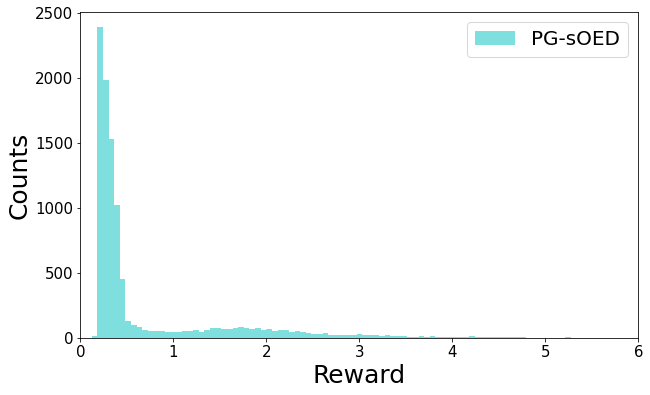

In [ ]:
plt.figure(figsize=(10,6))
bins = np.linspace(0, 6, 100)
plt.hist(soed.rewards_hist.sum(-1), alpha=0.5, bins=bins, color='c', 
         label='PG-sOED')
plt.xlim(0, 6)
plt.legend(fontsize=20)
plt.xlabel('Reward', fontsize=25)
plt.ylabel('Counts', fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

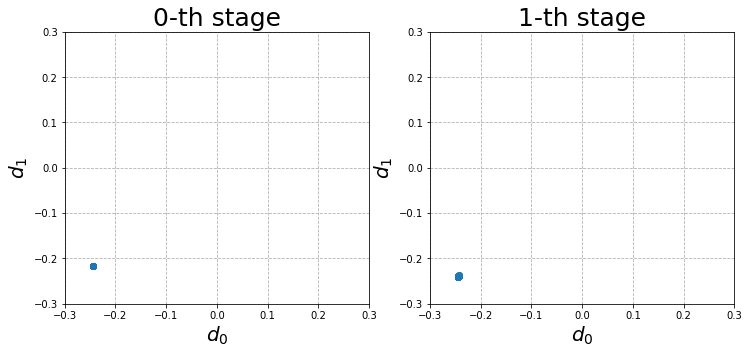

In [ ]:
plt.figure(figsize=(12, 5))
for k in range(2):
    plt.subplot(1, 2, k + 1)
    plt.scatter(soed.dcs_hist[:, k, 0], soed.dcs_hist[:, k, 1])
    plt.xlim(-0.3, 0.3)
    plt.ylim(-0.3, 0.3)
    plt.xlabel("$d_0$", fontsize=20)
    plt.ylabel("$d_1$", fontsize=20)
    plt.grid(ls='--')
    plt.title(f"{k}-th stage", fontsize=25)

reward: 0.2824314538334402


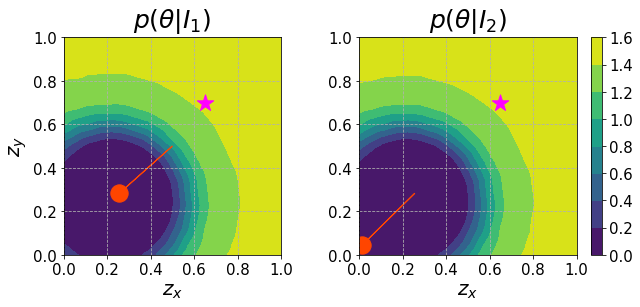

In [ ]:
# np.random.seed(112)
plt.figure(figsize=(11, 4))
x = np.linspace(0, 1, 50)
y = x
X, Y = np.meshgrid(x, y)
theta = np.random.random(size=2)
theta = np.array([0.65, 0.7])
d_hist = np.zeros((soed.n_stage, soed.n_design))
y_hist = np.zeros((soed.n_stage, soed.n_obs))
xp = np.array(soed.init_xp)
reward_hist = np.zeros(soed.n_stage + 1)
xb = soed.get_xb(None)
levels = None
for i in range(soed.n_stage + 1):
    if i > 0:
        xb = soed.get_xb(d_hist=d_hist[:i], y_hist=y_hist[:i])
        plt.subplot(1, 2, i, aspect='equal')
        plt.contourf(xb[:, 0].reshape(n_grid, n_grid),
                     xb[:, 1].reshape(n_grid, n_grid),
                     xb[:, -1].reshape(n_grid, n_grid), 
                     cmap='viridis', 
                     levels=levels)
        if i == n_stage:
            cbar = plt.colorbar()
            cbar.ax.tick_params(labelsize=15)
        plt.title(f"$p(\\theta|I_{i})$", fontsize=25, pad=10)
        plt.scatter(theta[0], theta[1], marker='*', s=300, c='magenta')
        plt.scatter(xp[0], xp[1], marker='o', s=300, c='orangered')
        plt.arrow(xp[0] - d_hist[i - 1, 0],
                  xp[1] - d_hist[i - 1, 1],
                  d_hist[i - 1, 0],
                  d_hist[i - 1, 1], 
                  color='orangered')
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.xticks(np.linspace(0, 1, 6), fontsize=15)
        plt.yticks(np.linspace(0, 1, 6), fontsize=15)
        plt.xlabel('$z_x$', fontsize=20)
        if i == 1:
            plt.ylabel('$z_y$', fontsize=20)
        plt.grid(which='both', ls='--')
        plt.subplots_adjust(wspace=0.05)
    if i < soed.n_stage:
        d_hist[i] = soed.get_design(i,
                                    d_hist=d_hist[:i], 
                                    y_hist=y_hist[:i])
        G = soed.m_f(i, theta.reshape(1, -1),
                     d_hist[i].reshape(1, -1), xp.reshape(1, -1)).flatten()
        y_hist[i] = np.random.normal(loc=G + 0 * noise_loc,
                                     scale=0 * soed.noise_b_s + 
                                     0 * soed.noise_r_s * np.abs(G))
        xp = soed.xp_f(xp, i, d_hist[i], y_hist[i])
    
    if i == soed.n_stage:
        d_in = None
        y_in = None
    else:
        d_in = d_hist[i]
        y_in = y_hist[i]
    reward_hist[i] = soed.get_reward(i, xb, xp, d_in, y_in)
print ('reward:', reward_hist.sum())